In [7]:
import numpy as np
import pandas as pd
from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.utils import HierarchicalPlot, is_strictly_hierarchical

from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast
# from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, ADIDA, CrostonClassic, TSB

from utilsforecast.losses import scaled_crps
from utilsforecast.losses import rmse, mase, msse


import datetime


import os


pd.set_option('display.max_columns', 500)

In [15]:
# Carrega os dados
dados_brutos = pd.read_csv("agg_vendas_vendedor_regiao.csv")
dados_brutos

df = dados_brutos[['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO', 'QUANTIDADE_PEDIDA', 'DATA_PEDIDO']]
group_cols = ['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO']

# Filtros
df = df[df['NOME_DA_LOJA'] != 'Compra Online']
df = df.dropna()

combinacoes_unicas = df.groupby(['NOME_DA_LOJA', 'NOME_PRODUTO']).size()
filtro = combinacoes_unicas[combinacoes_unicas > 10].index
df = df[df.set_index(['NOME_DA_LOJA', 'NOME_PRODUTO']).index.isin(filtro)]

# Muda o nome das colunas
df.rename(columns={'QUANTIDADE_PEDIDA': 'y', 'DATA_PEDIDO': 'ds'}, inplace=True)

# Conversão para DateTime
df['ds'] = pd.to_datetime(df['ds'])

# Ordena o dataframe
df = df.sort_values(group_cols + ['ds'])

# Remove duplicatas dentro de cada grupo somando 'y'
df = df.groupby(group_cols + ['ds'], as_index=False)['y'].sum()

# Define o intervalo de datas desejado
data_inicio = '2011-05-31'
data_fim = '2014-06-30'
date_range = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Preenchimento de datas missing
def fill_missing_dates(group):
    # Criar um DataFrame com a data e repetir as colunas de identificação
    df_template = pd.DataFrame({'ds': date_range})
    
    # Adiciona as colunas de identificação da série temporal
    for col in group_cols:
        df_template[col] = group[col].iloc[0]
    
    # Mescla os dados existentes com a grade completa de datas
    group = pd.merge(df_template, group, on=['ds'] + group_cols, how='left').fillna({'y': 0})
    
    return group

# Aplica a função de preenchimento para cada série temporal única
df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)

df = df.sort_values('ds')

id_columns = [col for col in df.columns if col not in ['y', 'ds']]
resampled = df.set_index('ds').groupby([pd.Grouper(freq='MS')] + id_columns)['y'].sum().reset_index()

df = resampled

/tmp/ipykernel_3163/1655192543.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)


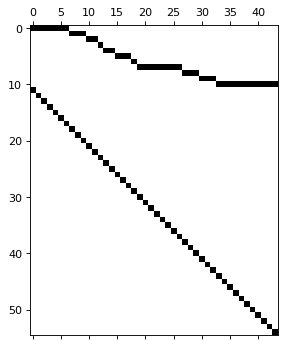

In [9]:
hierarquia = [
    ['NOME_DA_LOJA'],
    ['NOME_DA_LOJA', 'NOME_PRODUTO'],
]

Y_df, S_df, tags = aggregate(df, hierarquia)

h = 3
reconcilers = [BottomUp(),]
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [10]:
eval_tags = {}
eval_tags['Total'] = tags['NOME_DA_LOJA']
eval_tags['NOME_PRODUTO'] = tags['NOME_DA_LOJA/NOME_PRODUTO']

In [11]:
# Separa os dados em Treino e Teste

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(h)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_train_df

,unique_id,ds,y
0,Advanced Bike Components,2011-08-01,10
1,Advanced Bike Components,2011-10-01,16
2,Advanced Bike Components,2012-01-01,15
3,Advanced Bike Components,2012-04-01,24
4,Advanced Bike Components,2012-07-01,47
...,...,...,...
638,"Vigorous Exercise Company/Sport-100 Helmet, Red",2012-07-01,8
639,"Vigorous Exercise Company/Sport-100 Helmet, Red",2012-10-01,6
640,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-01-01,5
641,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-04-01,4


In [12]:
# Modelagem

models = [AutoARIMA(),]

fcst = StatsForecast(models=models, freq='MS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=h, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

In [18]:
from functools import partial

# Calcula as métricas

df = Y_hat_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df=df, tags=eval_tags, train_df=Y_train_df, metrics=[rmse, partial(mase, seasonality=4)])

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

display(evaluation.query('metric == "rmse"'))
display(evaluation.query('metric == "mase"'))

,level,metric,AutoARIMA
0,Total,rmse,9.77
2,NOME_PRODUTO,rmse,3.28
4,Overall,rmse,4.52


,level,metric,AutoARIMA
1,Total,mase,1.19
3,NOME_PRODUTO,mase,1.08
5,Overall,mase,1.10


In [20]:
# Reconciliação

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)

In [21]:
# Reconciliação

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)

In [22]:
# Avalia métricas com reconciliação
eval_df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'])

evaluation = evaluate(df = eval_df, tags = eval_tags, train_df = Y_train_df, metrics = [rmse, partial(mase, seasonality=4)])

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

evaluation.query('metric == "rmse"')

,level,metric,AutoARIMA,AutoARIMA/BottomUp_intervals_method-None_P-[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 1. 0. 0.]\n [0. 0. 0. ... 0. 1. 0.]\n [0. 0. 0. ... 0. 0. 1.]]_W-None_sampler-None_fitted-True
0,Total,rmse,9.77,6.88
2,NOME_PRODUTO,rmse,3.28,3.28
4,Overall,rmse,4.52,3.97


In [25]:
# Carrega os dados
dados_brutos = pd.read_csv("agg_vendas_vendedor_regiao.csv")
dados_brutos

df = dados_brutos[['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO', 'QUANTIDADE_PEDIDA', 'DATA_PEDIDO']]
group_cols = ['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO']

# Filtros
df = df[df['NOME_DA_LOJA'] != 'Compra Online']
df = df.dropna()

combinacoes_unicas = df.groupby(['NOME_DA_LOJA', 'NOME_PRODUTO']).size()
filtro = combinacoes_unicas[combinacoes_unicas > 10].index
df = df[df.set_index(['NOME_DA_LOJA', 'NOME_PRODUTO']).index.isin(filtro)]

# Muda o nome das colunas
df.rename(columns={'QUANTIDADE_PEDIDA': 'y', 'DATA_PEDIDO': 'ds'}, inplace=True)

# Conversão para DateTime
df['ds'] = pd.to_datetime(df['ds'])

# Ordena o dataframe
df = df.sort_values(group_cols + ['ds'])

# Remove duplicatas dentro de cada grupo somando 'y'
df = df.groupby(group_cols + ['ds'], as_index=False)['y'].sum()

# Define o intervalo de datas desejado
data_inicio = '2011-05-31'
data_fim = '2014-06-30'
date_range = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Preenchimento de datas missing
def fill_missing_dates(group):
    # Criar um DataFrame com a data e repetir as colunas de identificação
    df_template = pd.DataFrame({'ds': date_range})
    
    # Adiciona as colunas de identificação da série temporal
    for col in group_cols:
        df_template[col] = group[col].iloc[0]
    
    # Mescla os dados existentes com a grade completa de datas
    group = pd.merge(df_template, group, on=['ds'] + group_cols, how='left').fillna({'y': 0})
    
    return group

# Aplica a função de preenchimento para cada série temporal única
df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)

df = df.sort_values('ds')

id_columns = [col for col in df.columns if col not in ['y', 'ds']]
resampled = df.set_index('ds').groupby([pd.Grouper(freq='MS')] + id_columns)['y'].sum().reset_index()

df = resampled

/tmp/ipykernel_3163/1655192543.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)


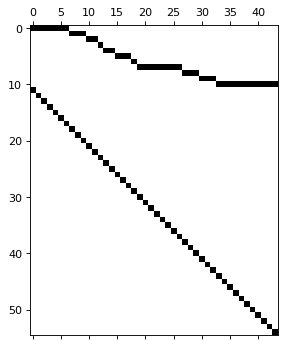

In [26]:
hierarquia = [
    ['NOME_DA_LOJA'],
    ['NOME_DA_LOJA', 'NOME_PRODUTO'],
]

Y_df, S_df, tags = aggregate(df, hierarquia)

h = 3
reconcilers = [BottomUp(),]
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [27]:
eval_tags = {}
eval_tags['Total'] = tags['NOME_DA_LOJA']
eval_tags['NOME_PRODUTO'] = tags['NOME_DA_LOJA/NOME_PRODUTO']

In [28]:
# Separa os dados em Treino e Teste

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(h)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_train_df

,unique_id,ds,y
0,Advanced Bike Components,2011-08-01,10
1,Advanced Bike Components,2011-10-01,16
2,Advanced Bike Components,2012-01-01,15
3,Advanced Bike Components,2012-04-01,24
4,Advanced Bike Components,2012-07-01,47
...,...,...,...
638,"Vigorous Exercise Company/Sport-100 Helmet, Red",2012-07-01,8
639,"Vigorous Exercise Company/Sport-100 Helmet, Red",2012-10-01,6
640,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-01-01,5
641,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-04-01,4


In [31]:
# Avaliação das métricas sem reconciliação

df = Y_hat_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df=df, tags=eval_tags, train_df=Y_train_df, metrics=[rmse, partial(mase, seasonality=4)])

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

display(evaluation.query('metric == "rmse"'))
display(evaluation.query('metric == "mase"'))

,level,metric,AutoARIMA
0,Total,rmse,9.77
2,NOME_PRODUTO,rmse,3.28
4,Overall,rmse,4.52


,level,metric,AutoARIMA
1,Total,mase,1.19
3,NOME_PRODUTO,mase,1.08
5,Overall,mase,1.10


In [33]:
# Reconcilia as predições

reconcilers = [BottomUp(),]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_mf = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)

In [38]:
evaluation.query("level == 'Overall'")

,level,metric,AutoARIMA
4,Overall,rmse,4.52
5,Overall,mase,1.10


In [41]:
# Carrega os dados
dados_brutos = pd.read_csv("agg_vendas_vendedor_regiao.csv")
dados_brutos

df = dados_brutos[['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO', 'QUANTIDADE_PEDIDA', 'DATA_PEDIDO']]
group_cols = ['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO']

# Filtros
df = df[df['NOME_DA_LOJA'] != 'Compra Online']
df = df.dropna()

combinacoes_unicas = df.groupby(['NOME_DA_LOJA', 'NOME_PRODUTO']).size()
filtro = combinacoes_unicas[combinacoes_unicas > 10].index
df = df[df.set_index(['NOME_DA_LOJA', 'NOME_PRODUTO']).index.isin(filtro)]

# Muda o nome das colunas
df.rename(columns={'QUANTIDADE_PEDIDA': 'y', 'DATA_PEDIDO': 'ds'}, inplace=True)

# Conversão para DateTime
df['ds'] = pd.to_datetime(df['ds'])

# Ordena o dataframe
df = df.sort_values(group_cols + ['ds'])

# Remove duplicatas dentro de cada grupo somando 'y'
df = df.groupby(group_cols + ['ds'], as_index=False)['y'].sum()

# Define o intervalo de datas desejado
data_inicio = '2011-05-31'
data_fim = '2014-06-30'
date_range = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Preenchimento de datas missing
def fill_missing_dates(group):
    # Criar um DataFrame com a data e repetir as colunas de identificação
    df_template = pd.DataFrame({'ds': date_range})
    
    # Adiciona as colunas de identificação da série temporal
    for col in group_cols:
        df_template[col] = group[col].iloc[0]
    
    # Mescla os dados existentes com a grade completa de datas
    group = pd.merge(df_template, group, on=['ds'] + group_cols, how='left').fillna({'y': 0})
    
    return group

# Aplica a função de preenchimento para cada série temporal única
df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)

df = df.sort_values('ds')

id_columns = [col for col in df.columns if col not in ['y', 'ds']]
resampled = df.set_index('ds').groupby([pd.Grouper(freq='MS')] + id_columns)['y'].sum().reset_index()

df = resampled


# Separa entre Estados Unidos e o restante do mundo
df['ESTADOS_UNIDOS'] = df['PAIS'].apply(lambda x: x == 'United States')#.replace({True: "Is USA", False: "Not USA"})

df_estadosunidos = df[df['ESTADOS_UNIDOS'] == True]
df_mundo = df[df['ESTADOS_UNIDOS'] == False]

/tmp/ipykernel_3163/1527792681.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)


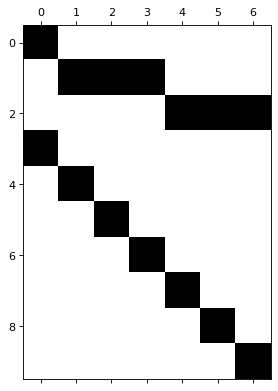

In [42]:
hierarquia = [
    ['NOME_DA_LOJA'],
    ['NOME_DA_LOJA', 'NOME_PRODUTO'],
]

Y_df, S_df, tags = aggregate(df_estadosunidos, hierarquia)

h = 3
reconcilers = [BottomUp(),]
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(h)
Y_train_df = Y_df.drop(Y_test_df.index)

eval_tags = {}
eval_tags['Total'] = tags['NOME_DA_LOJA']
eval_tags['NOME_PRODUTO'] = tags['NOME_DA_LOJA/NOME_PRODUTO']

In [43]:
# Modelagem

models = [AutoARIMA(),]

fcst = StatsForecast(models=models, freq='MS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=h, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

In [44]:
# Calcula as métricas

df = Y_hat_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df = df, tags = eval_tags, train_df = Y_train_df, metrics = [rmse, partial(mase, seasonality=4)])

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

evaluation.query('metric == "rmse"')

,level,metric,AutoARIMA
0,Total,rmse,4.28
2,NOME_PRODUTO,rmse,2.18
4,Overall,rmse,2.71


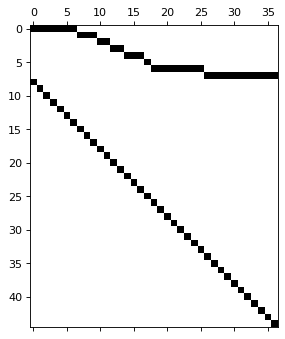

In [45]:
hierarquia = [
    ['NOME_DA_LOJA'],
    ['NOME_DA_LOJA', 'NOME_PRODUTO'],
]

Y_df, S_df, tags = aggregate(df_mundo, hierarquia)

h = 3
reconcilers = [BottomUp(),]
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(h)
Y_train_df = Y_df.drop(Y_test_df.index)

eval_tags = {}
eval_tags['Total'] = tags['NOME_DA_LOJA']
eval_tags['NOME_PRODUTO'] = tags['NOME_DA_LOJA/NOME_PRODUTO']

In [46]:
# Modelagem

models = [AutoARIMA(),]

fcst = StatsForecast(models=models, freq='MS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=h, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

In [47]:
# Calcula as métricas

df = Y_hat_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df = df, tags = eval_tags, train_df = Y_train_df, metrics = [rmse, partial(mase, seasonality=4)])

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

evaluation.query('metric == "rmse"')

,level,metric,AutoARIMA
0,Total,rmse,11.14
2,NOME_PRODUTO,rmse,3.46
4,Overall,rmse,4.85


In [49]:
# Carrega os dados
dados_brutos = pd.read_csv("agg_vendas_vendedor_regiao.csv")

# Seleciona apenas as luvas
luvas_ids = [id for id in dados_brutos['NOME_PRODUTO'].unique() if 'Glove' in id]
dados_brutos = dados_brutos[dados_brutos['NOME_PRODUTO'].isin(luvas_ids)]


df = dados_brutos[['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO', 'QUANTIDADE_PEDIDA', 'DATA_PEDIDO']]
group_cols = ['PAIS', 'ESTADO', 'NOME_DA_LOJA', 'NOME_PRODUTO']

# Filtros

# df = df[df['NOME_DA_LOJA'] != 'Compra Online']
df = df.dropna()

# Muda o nome das colunas
df.rename(columns={'QUANTIDADE_PEDIDA': 'y', 'DATA_PEDIDO': 'ds'}, inplace=True)

# Conversão para DateTime
df['ds'] = pd.to_datetime(df['ds'])

# Ordena o dataframe
df = df.sort_values(group_cols + ['ds'])

# Remove duplicatas dentro de cada grupo somando 'y'
df = df.groupby(group_cols + ['ds'], as_index=False)['y'].sum()

# Define o intervalo de datas desejado
data_inicio = '2011-05-31'
data_fim = '2014-06-30'
date_range = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Preenchimento de datas missing
def fill_missing_dates(group):
    # Criar um DataFrame com a data e repetir as colunas de identificação
    df_template = pd.DataFrame({'ds': date_range})
    
    # Adiciona as colunas de identificação da série temporal
    for col in group_cols:
        df_template[col] = group[col].iloc[0]
    
    # Mescla os dados existentes com a grade completa de datas
    group = pd.merge(df_template, group, on=['ds'] + group_cols, how='left').fillna({'y': 0})
    
    return group

# Aplica a função de preenchimento para cada série temporal única
df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)

df = df.sort_values('ds')

id_columns = [col for col in df.columns if col not in ['y', 'ds']]
resampled = df.set_index('ds').groupby([pd.Grouper(freq='MS')] + id_columns)['y'].sum().reset_index()

df = resampled

/tmp/ipykernel_3163/2111635899.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(group_cols, dropna=False).apply(fill_missing_dates).reset_index(drop=True)


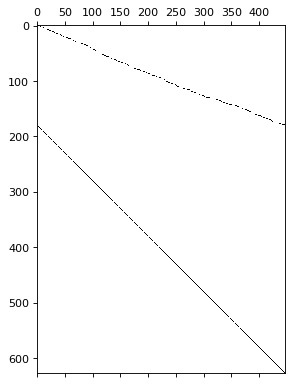

In [50]:
hierarquia = [
    ['NOME_DA_LOJA'],
    ['NOME_DA_LOJA', 'NOME_PRODUTO'],
]

Y_df, S_df, tags = aggregate(df, hierarquia)

h = 3
reconcilers = [BottomUp(),]
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(h)
Y_train_df = Y_df.drop(Y_test_df.index)

eval_tags = {}
eval_tags['Total'] = tags['NOME_DA_LOJA']
eval_tags['NOME_PRODUTO'] = tags['NOME_DA_LOJA/NOME_PRODUTO']

In [51]:
# Modelagem

models = [AutoARIMA(),]

fcst = StatsForecast(models=models, freq='MS', n_jobs=-1)
Y_hat_df = fcst.forecast(df=Y_train_df, h=h, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

/home/lais_silva/.local/lib/python3.10/site-packages/statsforecast/arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
/home/lais_silva/.local/lib/python3.10/site-packages/statsforecast/arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
/home/lais_silva/.local/lib/python3.10/site-packages/statsforecast/arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  fit["sigma2"] = np.nansum(fit["residuals"] ** 2) / (nstar - npar + 1)
/home/lais_silva/.local/lib/python3.10/site-packages/statsforecast/arima.py:1079: RuntimeWarning: divide by zero encountered in scalar divide
  tmp["aicc"] = tmp["aic"] + 2 * npar * (nstar / (nstar - npar - 1) - 1)
/home/lais_silva/.local/lib/python3.10/site-packages/statsforecast/arima.py:797: RuntimeWarning: divide by zero encountered in scalar divide
  f

In [52]:
# Calcula as métricas

df = Y_hat_df.merge(Y_test_df, on=['unique_id', 'ds'])
evaluation = evaluate(df = df, tags = eval_tags, train_df = Y_train_df, metrics = [rmse, partial(mase, seasonality=4)])

numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

evaluation.query('metric == "rmse"')

,level,metric,AutoARIMA
0,Total,rmse,9.69
2,NOME_PRODUTO,rmse,4.14
4,Overall,rmse,6.03


In [53]:
luvas_ids = [id for id in Y_hat_df['unique_id'].unique() if 'Glove' in id]

luvas_df = Y_hat_df[Y_hat_df['unique_id'].isin(luvas_ids)]
luvas_df.columns = ['unique_id', 'ds', 'AutoARIMA']
results = luvas_df[['ds', 'AutoARIMA']].groupby(['ds']).sum().sort_values('ds')
results

,AutoARIMA
ds,
2012-06-01,331.000000
2012-07-01,651.000000
2012-08-01,942.000000
2012-09-01,615.500000
2012-10-01,295.500000
2012-11-01,4.500000
2013-03-01,21.598530
2013-04-01,41.398727
2013-05-01,53.192482


In [57]:
#numero de luvas esperado : 4363
num_luvas_preditas = results["AutoARIMA"].sum()
print(num_luvas_preditas)

4363.044


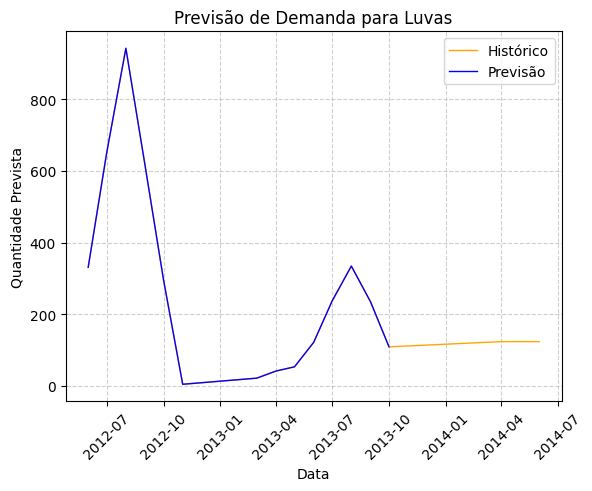

In [61]:
import matplotlib.pyplot as plt

plt.plot(results.index, results['AutoARIMA'], linewidth=1, color="orange", label="Histórico")

plt.plot(results.iloc[:-3].index, results.iloc[:-3]['AutoARIMA'], linewidth=1, color="blue", label="Previsão")

plt.xticks(rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade Prevista")
plt.title("Previsão de Demanda para Luvas")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()